In [1]:
#import numpy as np
import matplotlib.pyplot as plt
from src.csm_dp import * # this does "import numpy as np" too
from scipy.optimize import root_scalar
from scipy.integrate import quad
#import vegas
import sys
from scipy.integrate import cumulative_trapezoid
import time
sigma_SB = 5.67e-5 # erg/cm^2/s/K^4

### Create look up table for electron average stopping time and DP energy deposition efficiency

In [3]:
def average_stopping_time_eff(r,eps,mAp,SN_name='SN 2023ixf',SN_profile='LS220'):
    """
    Average stopping time for electron at CSM layer r

    In
    ---
    r : scalar
        CSM radius, cm
    eps : scalar
        Kinetic mixing parameter
    mAp : scalar
        Dark photon mass, MeV
    SN_name : str
        Name of the SN
    SN_profile : str
        Name of the SN explosion profile

    Out
    ---
    out : tup (a,b)
        a: The average stopping time for electron, s. If the stopping length is larger than r, the maximum length = r hence the time is r/c
        b: The energy deposition efficiency, 0-1
    """
    # Stopping length weighted by the EL distribution at layer r, s erg / cm / MeV
    def _weighted_length(EL):
        stop_length = CSM_electron_stopping_length(r,EL,SN_name)
        if stop_length < r:
            # stop length is smaller than the layer
            pass
        else:
            # we only care what happen withing this layer, the maximum propagation time is the layer radius / c
            stop_length = r
        return dQ_drdE(eps,mAp,r,EL,SN_profile)*stop_length

    def _weighted_efficiency(EL):
        stop_length = CSM_electron_stopping_length(r,EL,SN_name)
        if stop_length < r:
            # stop length is smaller than the layer, efficiency is 100%
            eff = 1
        else:
            # stop length is larger than r, energy depostion is not 100%
            eff = r / stop_length
        return dQ_drdE(eps,mAp,r,EL,SN_profile)*eff
        
    EL_weighted_time = quad(_weighted_length,1,501)[0] / c
    EL_weighted_eff = quad(_weighted_efficiency,1,501)[0]
    # Total energy will be deposited, s
    Q = dQ_dr(eps,mAp,r,SN_profile) #quad(lambda EL: dQ_drdE(eps,mAp,r,EL),1,501)[0]
    return (EL_weighted_time / Q),(EL_weighted_eff / Q)

In [7]:
eps_list = [1.5e-14,3.3e-14,1e-13,3.3e-13,1e-12,3.3e-12,1e-11]
mAp_list = np.logspace(2.99922e-02,2.7,50)
CSM_radius = np.logspace(np.log10(5e13),np.log10(8e15),35)

In [21]:
SN_profile = 'LS220'
total_jobs = len(eps_list)*len(mAp_list)
i=0
for eps in eps_list:
    for mAp in mAp_list:
        T_avg = []
        eff_avg = []
        for r in CSM_radius:
            tavg,eff = average_stopping_time_eff(r,eps,mAp,SN_profile=SN_profile)
            if tavg < 10:
                tavg = 10 # tavg cannot be smaller than the SN explosion duration 10s
            T_avg.append(tavg)
            eff_avg.append(eff)
        save_data = np.vstack([[eps]*len(CSM_radius),[mAp]*len(CSM_radius),CSM_radius,T_avg,eff_avg]).T
        with open(f"CSM_average_stoptime_efficiency_{SN_profile}.txt", "a") as f:
            np.savetxt(f, save_data, fmt='%.5e',delimiter=' ')
        i += 1
        sys.stdout.write(f"\rCurrent Progress: {i/total_jobs*100:.2f}%")
        sys.stdout.flush()

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_73433/2991769971.py:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  EL_weighted_time = quad(_weighted_length,1,501)[0] / c
/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_73433/2991769971.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

Current Progress: 94.86%

/var/folders/0d/rwlphr1x0sq99kpyh_g1pw8h0000gn/T/ipykernel_73433/2991769971.py:45: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  EL_weighted_time = quad(_weighted_length,1,501)[0] / c


Current Progress: 100.00%

### Create look up table for internal energy $u_{\rm gas}$ and $u_{\rm gas + rad}$

In [132]:
CSM_radius_large = np.logspace(np.log10(5e13),np.log10(8e15),300)
Temp_large = np.logspace(0,15,600)

In [134]:
total_jobs = len(CSM_radius_large)*len(Temp_large)
i = 0
u_gas = []
u_tot = []
for r in CSM_radius_large:
    u_gas_r = []
    u_tot_r = []
    for T in Temp_large:
        u_gas_r.append(u_total(r,T,include_rad=False))
        u_tot_r.append(u_total(r,T))
        # update progress
        i += 1
        sys.stdout.write(f"\rCurrent Progress: {i/total_jobs*100:.2f}%")
        sys.stdout.flush()
    u_gas.append(u_gas_r)
    u_tot.append(u_tot_r)
u_gas = np.array(u_gas)
u_tot = np.array(u_tot)

Current Progress: 100.00%

In [136]:
np.savetxt('src/internal_energy/u_total.txt',np.log10(u_tot),fmt = '%.5e')
np.savetxt('src/internal_energy/u_gas_only.txt',np.log10(u_gas),fmt = '%.5e')

### Evaluate thermal properties of CSM

In [5]:
eps_list = np.logspace(np.log10(1.5e-14),-11,100)
mAp_list = np.logspace(0,2.7,100)
CSM_radius = np.logspace(np.log10(5e13),np.log10(5e15),50)

number_of_mAp = len(mAp_list)

In [56]:
start_time = time.time()
# total_jobs = len(eps_list)
# j=0
SN_profile = 'TF' # SN profile
interp_u = True # use look up table for internal function
eps_val = 5e-13
mAp_val = 3
for eps in [eps_val] : # eps_list
    FBB_list = [] # for BB luminosity storage
    TBB_list = [] # ...    temperature ...
    RBB_list = [] # ...    radius      ...
    TAU_list = [] # ...    average tau ...
    GAS_TEMP_AT_1E15 = [] # for gas temp at 1e15 cm storage
    GAS_TEMP_AT_2E15 = [] # ...             2e15 ...
    GAS_TEMP_AT_3E15 = [] # ...             3e15 ...
    GAS_TEMP_AT_4E15 = [] # ...             4e15 ...
    for mAp in [mAp_val]: # mAp_list
        # creat empty list to store data
        T_wt_rad = [] # empty list to store temperature at different CSM radius with radiation in LTE
        T_wo_rad = [] # ...                                                     without radiation in LTE
        avg_time = average_stopping_time(eps,mAp,CSM_radius,SN_profile) # get average stopping time at different CSM radius
        avg_eff = average_efficiency(eps,mAp,CSM_radius,SN_profile)     # get average energy deposition efficiency at different CSM radius
        avg_eff[avg_eff > 1] = 1 # make sure efficiency cannot exceed 1
        avg_eff[avg_eff < 0] = 0 # ...                         below 0

        Q_dot = dQ_dV(CSM_radius,eps,mAp) * avg_eff / avg_time # energy deposition rate at different CSM radius
        
        for i in range(len(CSM_radius)):
            r = CSM_radius[i]
            # Get temperature with radiation in LTE
            try:
                T_rad,_,_ = get_T(r,eps,mAp,efficiency=avg_eff[i],interp_u=interp_u)
            except:
                # check the solver fails at this point is due to dQ is too small to raise any temperature or too large that breaks the upper bracket
                if dQ_dV(r,eps,mAp) <= 1e-2: # dQ_dV is too low to raise meaningful T
                    T_rad = 1 # Let it truncates at 1 K
                else:
                    T_rad = np.nan # fail to find solution
            T_wt_rad.append(T_rad)
            
            # Get gas only temperature, not in LTE (radiation is not included)
            try:
                T_norad,_,_ = get_T(r,eps,mAp,include_rad=False,efficiency=avg_eff[i],interp_u=interp_u)
            except:
                # check the solver fails at this point is due to dQ is too small to raise any temperature or too large that breaks the upper bracket
                if dQ_dV(r,eps,mAp) <= 1e-2:
                    T_norad = 1 # Let it truncates at 1 K
                else:
                    T_norad = np.nan # fail to find solution
            T_wo_rad.append(T_norad)

        # Get optical depth
        rho = CSM_density(CSM_radius)
        dtau = kappa(rho,T_wt_rad) * rho # opacity * density
        # if dtau is nan, that means it is beyond the valid range of Ferguson/OPAL tables, this happens when T < 600 K
        # this means the gas becomes transparent, thus make dtau 0
        dtau[np.isnan(dtau)] = 0
        # calculate average tau at different CSM radius
        int_0_to_i = cumulative_trapezoid(dtau, CSM_radius, initial=0)
        total_integral = int_0_to_i[-1]
        opt_depth = total_integral - int_0_to_i
        opt_depth[opt_depth < 1e-20] = 1e-20 # average to small or negative, truncate it at 1e-20 to avoid numerical error for later use
        
        # Get the photosphere radius
        r_photo = 10**np.interp(np.log10(2/3),np.log10(opt_depth[:-1])[::-1],np.log10(CSM_radius[:-1])[::-1], left=np.nan, right=np.nan)
        if np.isnan(r_photo) is not True:
            # r_photo exists
            # Get the photosphere temperature
            T_photo = 10**np.interp(np.log10(r_photo),np.log10(CSM_radius[:-1]),np.log10(T_wt_rad[:-1]), left=np.nan, right=np.nan)
        else: # r_photo does not exist
            T_photo = np.nan
        
        # Get the blackbody radiation at surface
        if np.isnan(r_photo) is not True:
            F_BB = 4 * np.pi * r_photo**2 * sigma_SB * T_photo**4
        else:
            F_BB = np.nan
        
        # Get average tau before r_photo
        R_to_photo = np.append(CSM_radius[CSM_radius < r_photo], r_photo)
        tau_to_photo = np.append(opt_depth[CSM_radius < r_photo], 2/3)
        # Get the area and perform trapozoidial integration
        area = np.trapz(tau_to_photo, R_to_photo)
        avg_tau = area / (R_to_photo.max() - R_to_photo.min())

        # Get cooling rate
        cool_rate = CSM_radiative_cooling_rate(CSM_radius,4000)
        cool_rate[CSM_radius > r_photo] = CSM_radiative_cooling_rate(CSM_radius,T_wo_rad)[CSM_radius > r_photo]

        # Get the gas temperature at dust region
        T_gas_1e15 = 10**np.interp(np.log10(1e15),np.log10(CSM_radius[:-1]),np.log10(T_wo_rad[:-1]), left=np.nan, right=np.nan)
        T_gas_2e15 = 10**np.interp(np.log10(2e15),np.log10(CSM_radius[:-1]),np.log10(T_wo_rad[:-1]), left=np.nan, right=np.nan)
        T_gas_3e15 = 10**np.interp(np.log10(3e15),np.log10(CSM_radius[:-1]),np.log10(T_wo_rad[:-1]), left=np.nan, right=np.nan)
        T_gas_4e15 = 10**np.interp(np.log10(4e15),np.log10(CSM_radius[:-1]),np.log10(T_wo_rad[:-1]), left=np.nan, right=np.nan)

        TAU_list.append(avg_tau) # list of average tau for various mAp at given eps
        RBB_list.append(r_photo) # list of r_photo for various mAp at given eps
        TBB_list.append(T_photo) # list of T_photo for various mAp at given eps
        FBB_list.append(F_BB) # # list of photosphere luminosity for various mAp at given eps
        GAS_TEMP_AT_1E15.append(T_gas_1e15) # list of gas temperature at 1e15 cm for various mAp at given eps
        GAS_TEMP_AT_2E15.append(T_gas_2e15) # ...                        2e15 ...
        GAS_TEMP_AT_3E15.append(T_gas_3e15) # ...                        3e15 ...
        GAS_TEMP_AT_4E15.append(T_gas_4e15) # ...                        4e15 ...

    # # uncomment below if you want to save data
    # save_data = np.vstack([[eps]*number_of_mAp,
    #                        [mAp]*number_of_mAp,
    #                        TAU_list,
    #                        RBB_list,
    #                        TBB_list,
    #                        FBB_list,
    #                        GAS_TEMP_AT_1E15,
    #                        GAS_TEMP_AT_2E15,
    #                        GAS_TEMP_AT_3E15,
    #                        GAS_TEMP_AT_4E15]).T
    # with open(f"CSM_constraint_data_{SN_profile}.txt", "a") as f:
    #     np.savetxt(f, save_data, fmt='%.5e',delimiter=' ')
    # j += 1
    # sys.stdout.write(f"\rCurrent Progress: {j/total_jobs*100:.2f}%")
    # sys.stdout.flush()
end_time = time.time()
print(f"\nElapsed time: {end_time - start_time:.6f} seconds")


Elapsed time: 0.079930 seconds


Text(0, 0.5, '$T$ [K]')

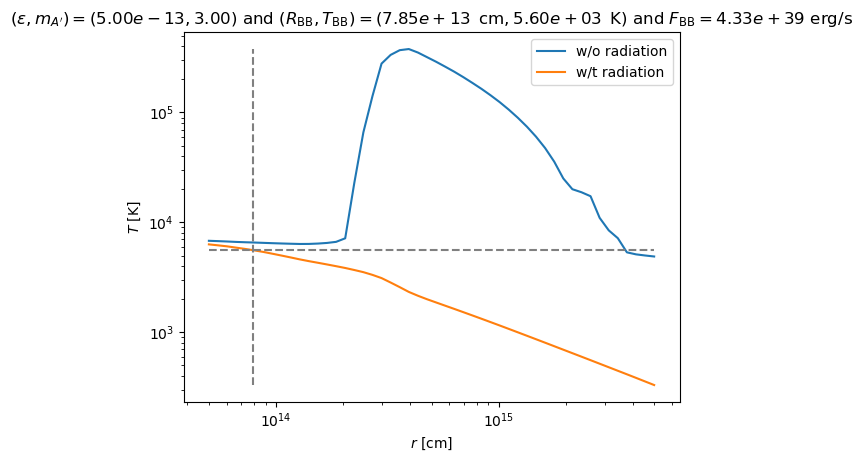

In [58]:
plt.plot(CSM_radius,T_wo_rad,label='w/o radiation')
plt.plot(CSM_radius,T_wt_rad,label='w/t radiation')
if np.isnan(r_photo) is not True:
    # r_photo exists, corresponds to tau = 2/3
    plt.plot([r_photo,r_photo],[min(T_wt_rad),max(T_wo_rad)],'--',color='gray')
    plt.plot([CSM_radius[0],CSM_radius[-1]],[T_photo,T_photo],'--',color='gray')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(CSM_radius[0]/1.3,CSM_radius[-1]*1.3)
plt.title(fr'$(\epsilon,m_{{A^\prime}})=({eps:.2e},{mAp:.2f})$ and $(R_{{\rm BB}},T_{{\rm BB}})=({r_photo:.2e}{{\rm~\,cm}},{T_photo:.2e}{{\rm~\,K}})$ and $F_{{\rm BB}}={F_BB:.2e}$ erg/s')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$T$ [K]')
#plt.ylim(2500,)
#plt.savefig('T.png',bbox_inches='tight')

Text(0.5, 1.0, '$\\epsilon=3.162e-13$ and $m_{A^\\prime}=300.00$ MeV and $\\bar{\\tau}=35.73$')

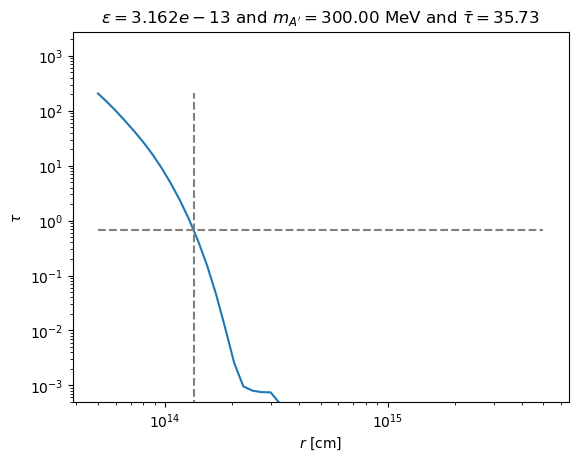

In [46]:
plt.plot(CSM_radius,opt_depth)
plt.plot([CSM_radius[0],CSM_radius[-1]],[2/3,2/3],'--',color='gray')
if np.isnan(r_photo) is not True:
    # r_photo exists, corresponds to tau = 2/3
    plt.plot([r_photo,r_photo],[min(opt_depth),max(opt_depth)],'--',color='gray')
plt.xscale('log')
plt.yscale('log')
#plt.legend()
plt.xlim(CSM_radius[0]/1.3,CSM_radius[-1]*1.3)
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\tau$')
plt.ylim(5e-4,)
plt.title(fr'$\epsilon={eps:.3e}$ and $m_{{A^\prime}}={mAp:.2f}$ MeV and $\bar{{\tau}}={avg_tau:.2f}$')
#plt.savefig('tau.png',bbox_inches='tight')

Text(0.5, 1.0, '$\\epsilon=3.162e-13$ and $m_{A^\\prime}=300.00$ MeV')

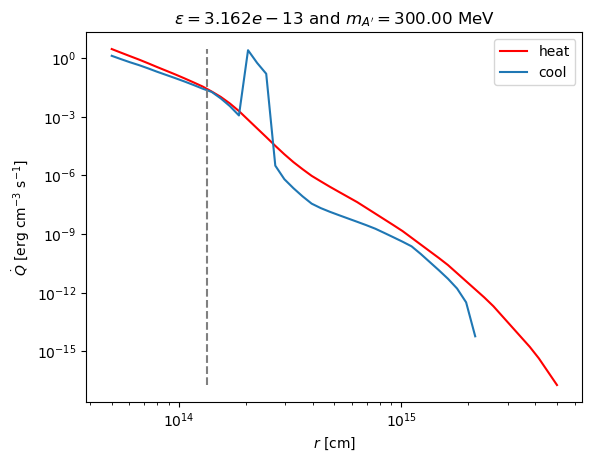

In [48]:
plt.plot(CSM_radius,Q_dot,color='red',label='heat')
plt.plot(CSM_radius,cool_rate,color='C0',label='cool')
if np.isnan(r_photo) is not True:
    # r_photo exists, corresponds to tau = 2/3
    plt.plot([r_photo,r_photo],[min(Q_dot),max(Q_dot)],'--',color='gray')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(CSM_radius[0]/1.3,CSM_radius[-1]*1.3)
#plt.ylim(np.max(Q_dot)/100,np.max(Q_dot)*100)
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\dot{Q}$ [erg cm$^{-3}$ s$^{-1}$]')
plt.title(fr'$\epsilon={eps:.3e}$ and $m_{{A^\prime}}={mAp:.2f}$ MeV')
#plt.savefig('rate.png',bbox_inches='tight')

In [50]:
Q_dot/cool_rate

array([2.21790412e+00, 2.14246194e+00, 2.05596573e+00, 1.92357895e+00,
       1.82033625e+00, 1.74046472e+00, 1.64247051e+00, 1.54831225e+00,
       1.44767508e+00, 1.35728358e+00, 1.28962091e+00, 1.04642727e+00,
       1.19245401e+00, 1.36702864e+00, 1.67891638e+00, 2.79162083e-04,
       4.49416558e-04, 5.80713870e-04, 1.02967561e+01, 1.88636052e+01,
       2.15292732e+01, 2.44752488e+01, 2.63807804e+01, 2.33601765e+01,
       1.91008012e+01, 1.55236022e+01, 1.25741089e+01, 1.01760567e+01,
       7.66884971e+00, 5.91834828e+00, 4.94561800e+00, 4.17561196e+00,
       3.49585123e+00, 2.74175806e+00, 3.02171516e+00, 3.56856187e+00,
       4.21930213e+00, 5.02124971e+00, 6.08228178e+00, 1.19964876e+01,
       2.51981520e+02,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])

Text(0, 0.5, '$\\kappa$ [cm$^2$ g$^{-1}$]')

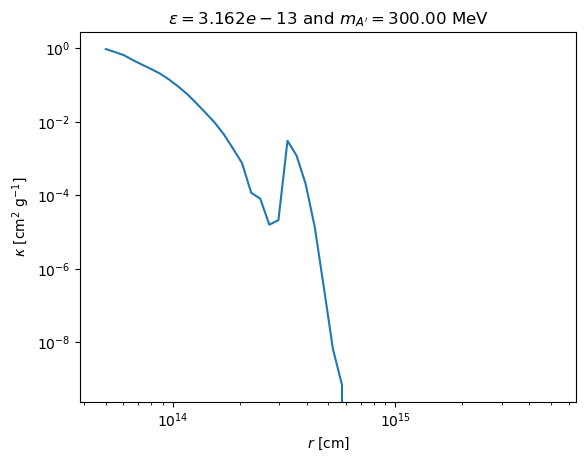

In [52]:
plt.plot(CSM_radius,dtau/rho)
# if np.isnan(r_photo) is not True:
#     # r_photo exists, corresponds to tau = 2/3
#     plt.plot([r_photo,r_photo],[min(T_wt_rad),max(T_wo_rad)],'--',color='gray')
#     plt.plot([CSM_radius[0],CSM_radius[-1]],[T_photo,T_photo],'--',color='gray')

plt.xscale('log')
plt.yscale('log')
plt.xlim(CSM_radius[0]/1.3,CSM_radius[-1]*1.3)
plt.title(fr'$\epsilon={eps:.3e}$ and $m_{{A^\prime}}={mAp:.2f}$ MeV')
plt.xlabel(r'$r$ [cm]')
plt.ylabel(r'$\kappa$ [cm$^2$ g$^{-1}$]')

### Load constrain data

In [60]:
SN_profile = 'TF'
constraint = np.loadtxt(f'CSM_constraint_data_{SN_profile}.txt')
constraint_tau = constraint[:, 2].reshape(100,100)
constraint_RBB = constraint[:, 3].reshape(100,100)
constraint_FBB = constraint[:, 5].reshape(100,100)
constraint_T_GAS_1E15 = constraint[:, 6].reshape(100,100)
constraint_T_GAS_2E15 = constraint[:, 7].reshape(100,100)
constraint_T_GAS_3E15 = constraint[:, 8].reshape(100,100)
constraint_T_GAS_4E15 = constraint[:, 9].reshape(100,100)

np.nan_to_num(constraint_tau, copy=False, nan=0.0)
np.nan_to_num(constraint_FBB, copy=False, nan=0.0)
np.nan_to_num(constraint_RBB, copy=False, nan=0.0)
sn1987a_gamma_data = np.log10(np.loadtxt('sn1987a_gamma.txt'))

constraint_diff_time = constraint_tau*constraint_RBB / c

Text(0.5, 1.0, 'TF with $\\bar{t}_{\\rm diff}>1.0$ d')

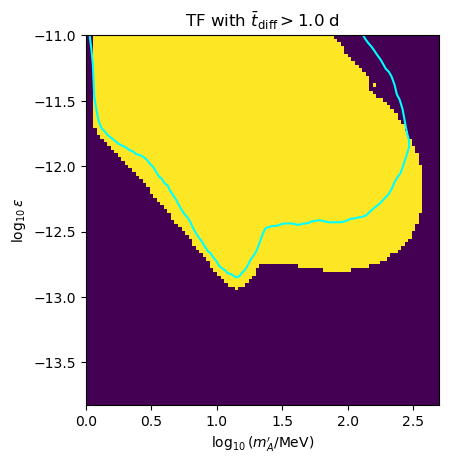

In [62]:
d = 1
plt.imshow(constraint_diff_time>(86400*d),origin='lower',extent=[0, 2.7, np.log10(1.5e-14), -11]) # need to make sure the x,y ranges are properly matched
plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],color='cyan')
plt.ylim(np.log10(1.5e-14), -11)
plt.xlabel(r'$\log_{10}(m_{A}^\prime/{\rm MeV})$')
plt.ylabel(r'$\log_{10}\epsilon$')
plt.title(fr'{SN_profile} with $\bar{{t}}_{{\rm diff}}>{d:.1f}$ d')
#plt.savefig(f'diff_time_one_day_{SN_profile}.png',bbox_inches='tight')


Text(0.5, 1.0, 'TF with $F_{\\rm BB}>1.0e+40$ erg/s')

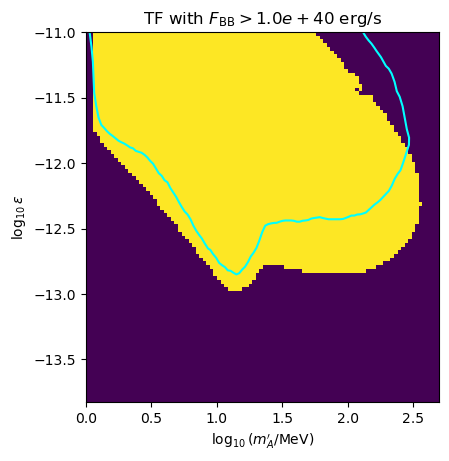

In [64]:
F_BB = 1e40
plt.imshow(constraint_FBB>F_BB,origin='lower',extent=[0, 2.7, np.log10(1.5e-14), -11])
plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],color='cyan')
plt.ylim(np.log10(1.5e-14), -11)
plt.xlabel(r'$\log_{10}(m_{A}^\prime/{\rm MeV})$')
plt.ylabel(r'$\log_{10}\epsilon$')
plt.title(fr'{SN_profile} with $F_{{\rm BB}}>{F_BB:.1e}$ erg/s')
#plt.savefig(f'obs_luminosity_{SN_profile}.png',bbox_inches='tight')

Text(0.5, 1.0, 'TF with $T_{\\rm gas}>3000~{\\rm K}@1\\times 10^{15}~{\\rm cm}$')

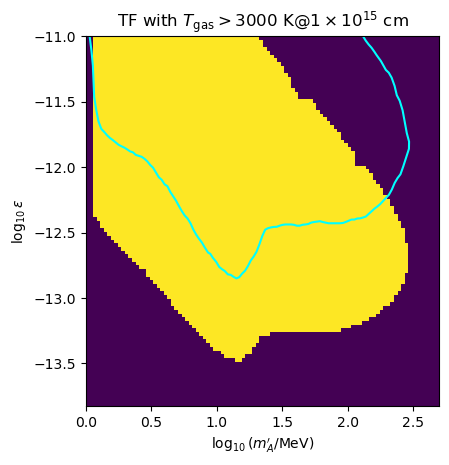

In [68]:
T_g_th = 3000
plt.imshow(constraint_T_GAS_1E15>T_g_th,origin='lower',extent=[0, 2.7, np.log10(1.5e-14), -11])
plt.plot(sn1987a_gamma_data.T[0],sn1987a_gamma_data.T[1],color='cyan')
plt.ylim(np.log10(1.5e-14), -11)
plt.xlabel(r'$\log_{10}(m_{A}^\prime/{\rm MeV})$')
plt.ylabel(r'$\log_{10}\epsilon$')
plt.title(fr'{SN_profile} with $T_{{\rm gas}}>{T_g_th:.0f}~{{\rm K}}@1\times 10^{{15}}~{{\rm cm}}$')
#plt.savefig(f'dust_{SN_profile}.png',bbox_inches='tight')